# PTM PPI Shortcut analysis

In [1]:
import sys, pandas as pd, os, matplotlib.pyplot as plt, sklearn
from sklearn import tree

sys.path.append("../src")
from utils.s3_utils import download_file



all_labels = list(range(7))
pos_labels = list(range(1,7,1))
label_names = ["other",
                            "phosphorylation",
                            "dephosphorylation",
                            "methylation",
                            "ubiquitination",
                            "acetylation",
                            "deubiquitination"]

renamed_labels = ["Negative"] + [i.title() for i in label_names[1:]]

ptm_trigger_words =  ["phosphorylation", "deubiquitination", "acetylation", "ubiquitination", "methylation", "dephosphorylation"]



## Original inputs with markers
For how to create the preprocessed file for PTM-PPI, see https://github.com/elangovana/large-scale-ptm-ppi/blob/main/src/utils/static_markers_ppi_multiclass.py

In [2]:
temp_dir = "temp"

In [3]:
trainfile="../temp/markers_train_multiclass.json"
testfile="../temp/markers_test_multiclass.json"
valfile="../temp/markers_val_multiclass.json"


In [4]:
s3_generalisation = "s3://aegovan-data/pubmed_asbtract/predictions_largescale_ppimulticlass-bert-f1-2021-05-10-10_2022-07-01_negative_generalisation/"
s3_large_scale_high_q = "{}/highquality_sample.json".format(s3_generalisation.rstrip("/"))
s3_large_scale_low_q = "{}/lowquality_sample.json".format(s3_generalisation.rstrip("/"))

## Predictions with markers

In [5]:
largescalefile = "../temp/markers_largescale_hq_above_threshold.json"
largescale_low_hq="../temp/markers_largescale_lq_below_threshold.json"

test_predictions_file ="../temp/markers_test_pred_multiclass.json"

In [6]:
def load_large_scale(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x) )
    df["y_raw"] = df["prediction"]


    return df

def load_valtest_ensemble_pred(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x) )
    df["y_raw"] = df["prediction"]


    return df

In [7]:
from model_nb_relation_classifier import ModelNBRelationClassifier
from model_nb_tree_relation_classifier import ModelNBTreeRelationClassifier
from model_tree_relation_classifier import ModelTreeRelationClassifier

NAIVE_BAYES="Naive Bayes"
NAIVE_BAYES_WITH_TREE = "Naive Bayes + Tree"
TREE = "Tree"


def  train_and_predict_all_classifiers(df, min_df=None):
    
    max_words_per_class = 1000
    max_tree_depth = 4
    
    classifiers = {
        NAIVE_BAYES : ModelNBRelationClassifier( max_words_per_class=max_words_per_class, min_df=min_df),
        NAIVE_BAYES_WITH_TREE : ModelNBTreeRelationClassifier("PROTPART1", "PROTPART0", min_df=min_df, max_words_per_class=max_words_per_class, trigger_words=ptm_trigger_words, max_tree_depth=max_tree_depth),
 #       TREE : ModelTreeRelationClassifier("PROTPART1", "PROTPART0",  trigger_words=ptm_trigger_words, max_tree_depth=max_tree_depth)

    }
   
    
    result = {}
    for k, m in classifiers.items():
        
        print(f"Training {k}")
        
        m.train(df["x"], df["y"])
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
            "predictions_conf": p_conf
        }
    return result

def  predict_all_classifiers(df, models_dict):
    max_words_per_class = 10
    max_tree_depth = 4
    
   
    
    result = {}
    for k, v in models_dict.items():
        m = v["m"]
        
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
            "predictions_conf": p_conf
        }
    return result


In [8]:
def isint(a):
    try:
        t = int(a)
        return True
    except:
        return False
    
def float_percent_format(x):
     return "{:.1f}".format(x*100)

def int_format(x):
     return str(int(x))

def print_report(actual, pred, labels=None, label_names = renamed_labels):

    pos_f1 = sklearn.metrics.f1_score(actual, pred, labels=labels, average='micro',
                                  sample_weight=None, zero_division=0)
    all_f1 = sklearn.metrics.f1_score(actual, pred, average='micro', sample_weight=None, zero_division=0)
    
        
    d = sklearn.metrics.classification_report(actual,
                                            pred,
                                            output_dict=True,
                                            labels=labels,zero_division=0)
    df =  pd.DataFrame(d).T
    df.index = list(map(lambda x: label_names[int(x)] if isint( x) else x, df.index))
    df.insert(1, "index", df.index)


    return df
    
def print_report_all_classifiers(actual, results_dict, *args, **kwargs):
    result = []
    for k, v in results_dict.items():
        df = print_report(actual,v["predictions"],  *args, **kwargs)
        df.insert (0, "model", k)
        
        result.append(df)
    df = pd.concat(result)
    print(df.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format }))
    return df
        
        

In [9]:
def prep_data(df, m):
    df_t = df.copy(deep=True)
    df_t["nb_pred"] = m["predictions"]
    df_t["nb_pred_conf"] = m["predictions_conf"]
    df_t["nb_pred_raw"] = df_t["nb_pred"].apply(lambda i: label_names[i])
    return df_t

def plot_confidence(df_t):
    labels =  list(df_t["y_raw"].unique())   
    print(labels)
    _ , ax = plt.subplots(len(labels),1, figsize=(10,15))



    for i,l in enumerate(labels):
        t = df_t.query(f"y_raw == '{l}'")

        ax[i].set_ylim(0,1)


        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

        ax[i].spines['bottom'].set_color('grey')
        ax[i].spines['top'].set_color('grey') 
        ax[i].spines['right'].set_color('grey')
        ax[i].spines['left'].set_color('grey')



        ax[i].violinplot(t["confidence"],  showmeans=True )
        ax[i].set_title(f"{l}")


# plot_confidence(prep_data(df_largescale_hq, result_largescale_hq[NAIVE_BAYES_WITH_TREE]))

# plt.show()




In [10]:
from dtreeviz.trees import *

def plot_tree(m):
    _, ax = plt.subplots(1,1, figsize=(45,15))

    tree.plot_tree(m.tree_model, ax=ax, fontsize=10, feature_names=m.feature_names, filled=True, rounded=True)

    plt.show()
    
def plot_tree_pretty(m, x, y, title="", image_save_path=None):
    import sys
    dot_path = '/opt/homebrew/bin/'
    if dot_path not in sys.path :
        sys.path.append( dot_path)
        for p in sys.path:
            os.environ["PATH"] = os.environ.get("PATH","") + ":" +  p

    viz = dtreeviz(m.tree_model,
               x_data=m.extract_features(x),
               y_data=y,
               target_name='class',
               feature_names=m.feature_names,
               class_names=label_names,
               title=title)
    
    return viz
    # tree_plt.view()    
    if image_save_path:
        tree_plt.save(image_save_path)

In [11]:
def get_top_discrimintary_keywords(model, label_index ) :
    index_to_vocab = {i:v  for v,i in model.vocab.items()}
    
    #. ( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])]

    return sorted( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])], 
           reverse=True, key=lambda x: x[1])[:50]




In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def consolidate_label_names(actual, pred, label_names):
    label_indices = list(set(actual).union(pred))
    return [label_names[i] for i in sorted(label_indices)]

def plot_confusionmatrix(y_true,y_pred):
    cm = confusion_matrix(y_true,y_pred)
    labels = consolidate_label_names( y_true,y_pred,label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    disp.plot(cmap="PuBu", xticks_rotation="vertical")
    

## Train GT Train predictions

In [13]:
df_train = pd.read_json(trainfile, orient="records")
train_result = train_and_predict_all_classifiers(df_train)

print_report_all_classifiers(df_train["y"], train_result,  pos_labels)

print_report_all_classifiers(df_train["y"], train_result,  all_labels)



Training Naive Bayes
Max words :  1097
Training Naive Bayes + Tree
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      37.5 &   Phosphorylation &   74.8 &     50.0 &     139 \\
       Naive Bayes &      26.9 & Dephosphorylation &   64.3 &     37.9 &      28 \\
       Naive Bayes &      35.7 &       Methylation &  100.0 &     52.6 &      10 \\
       Naive Bayes &      66.7 &    Ubiquitination &   40.0 &     50.0 &       5 \\
       Naive Bayes &      50.0 &       Acetylation &   40.0 &     44.4 &       5 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       2 \\
       Naive Bayes &      35.9 &         micro avg &   72.0 &     47.9 &     189 \\
       Naive Bayes &      36.1 &         macro avg &   53.2 &     39.2 &     189 \\
       Naive Bayes &      36.6 &      weighted avg &   72.0 &     47.7 &     189 \\
Naive Bayes + Tree &      76.2 &   Phosphorylation 

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.946004,Negative,0.784946,0.857982,1116.000000
Phosphorylation,Naive Bayes,0.375451,Phosphorylation,0.748201,0.500000,139.000000
Dephosphorylation,Naive Bayes,0.268657,Dephosphorylation,0.642857,0.378947,28.000000
Methylation,Naive Bayes,0.357143,Methylation,1.000000,0.526316,10.000000
Ubiquitination,Naive Bayes,0.666667,Ubiquitination,0.400000,0.500000,5.000000
Acetylation,Naive Bayes,0.500000,Acetylation,0.400000,0.444444,5.000000
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,2.000000
accuracy,Naive Bayes,0.775479,accuracy,0.775479,0.775479,0.775479
macro avg,Naive Bayes,0.444846,macro avg,0.568001,0.458241,1305.000000
weighted avg,Naive Bayes,0.861958,weighted avg,0.775479,0.802762,1305.000000


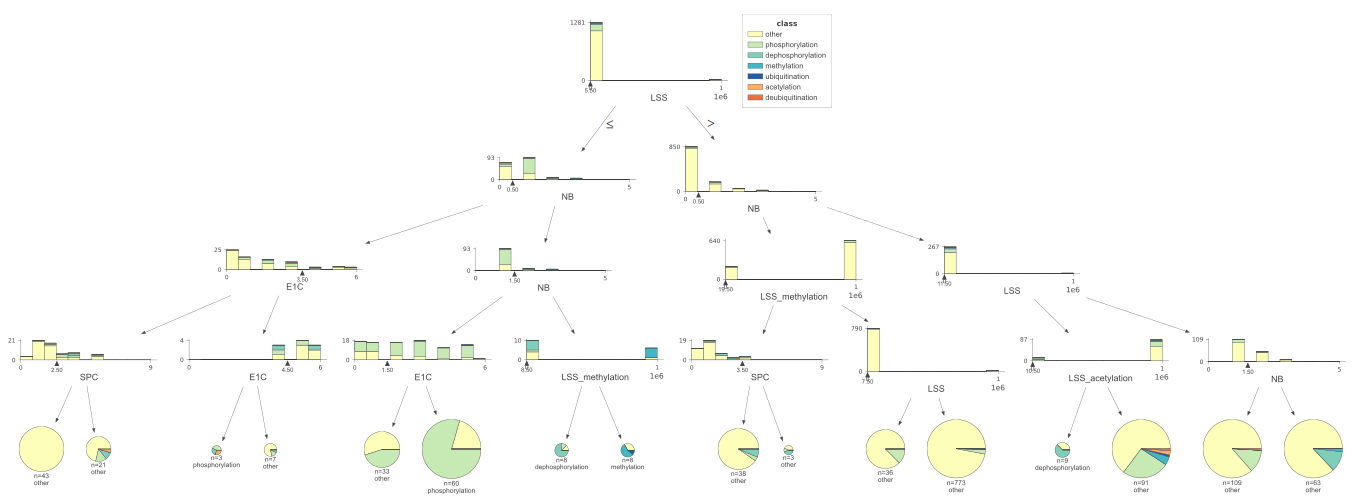

In [14]:
#plot_tree(train_result[NAIVE_BAYES_WITH_TREE]["m"])

plot_tree_pretty(train_result[NAIVE_BAYES_WITH_TREE]["m"], df_train["x"], df_train["y"])

In [15]:
get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],0)

[('protpart1', -2.780079393968938),
 ('protpart0', -2.78567347398344),
 ('prtig0', -3.1145163517328998),
 ('prtig1', -3.318694830141215),
 ('prtig2', -3.5511291210754203),
 ('phosphorylation', -3.688037247482911),
 ('prtig3', -3.7526158576180624),
 ('kinase', -4.402455360673299),
 ('cells', -4.412331984169211),
 ('prtig4', -4.465847937509318),
 ('protein', -4.527946157627615),
 ('activation', -4.588222650632875),
 ('induced', -4.647646071103676),
 ('activity', -4.825894302509995),
 ('phosphorylated', -4.839114513938129),
 ('cell', -4.926471612625239),
 ('tyrosine', -4.951683031971735),
 ('binding', -5.006341444509599),
 ('expression', -5.098062567074106),
 ('vitro', -5.143410387052565),
 ('proteins', -5.174826583285944),
 ('complex', -5.188213664068404),
 ('results', -5.188213664068404),
 ('domain', -5.2100128924109885),
 ('dependent', -5.2294849958238085),
 ('vivo', -5.410683587873139),
 ('mediated', -5.437989038563407),
 ('activated', -5.455441488514633),
 ('response', -5.46962612350

In [16]:
get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],1)

[('protpart1', -2.4315506444220425),
 ('protpart0', -2.5502946246235094),
 ('prtig0', -3.5095212442028085),
 ('phosphorylation', -3.636621746497041),
 ('prtig1', -3.757155815525314),
 ('kinase', -4.189847736333693),
 ('prtig2', -4.4019064552234095),
 ('phosphorylated', -4.5275946703869066),
 ('cells', -4.554745659452857),
 ('protein', -4.573264707220095),
 ('activation', -4.650973691547411),
 ('activity', -4.681745350214165),
 ('cell', -4.735234035165151),
 ('induced', -4.803442285191684),
 ('tyrosine', -4.9420284484778305),
 ('binding', -5.011987037084741),
 ('vitro', -5.0564387996555755),
 ('prtig3', -5.1517489794599),
 ('domain', -5.185650531135582),
 ('results', -5.220741850946851),
 ('protpart1 protpart1', -5.257109495117726),
 ('human', -5.257109495117726),
 ('interaction', -5.3142679089576745),
 ('complex', -5.354273243571374),
 ('dependent', -5.37489253077411),
 ('expression', -5.37489253077411),
 ('phosphorylates', -5.37489253077411),
 ('protpart1 protpart0', -5.39594593997194

## Val GT predictions


In [17]:
df_val = pd.read_json(valfile, orient="records")
result_val = train_and_predict_all_classifiers(df_val, min_df=1)

print_report_all_classifiers(df_val["y"], result_val,  pos_labels)

print_report_all_classifiers(df_val["y"], result_val,  all_labels)



Training Naive Bayes
Max words :  2790
Training Naive Bayes + Tree
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      38.6 &   Phosphorylation &   81.0 &     52.3 &      21 \\
       Naive Bayes &      34.5 & Dephosphorylation &  100.0 &     51.3 &      10 \\
       Naive Bayes &      16.7 &       Methylation &  100.0 &     28.6 &       1 \\
       Naive Bayes &      16.7 &    Ubiquitination &  100.0 &     28.6 &       1 \\
       Naive Bayes &      33.3 &       Acetylation &  100.0 &     50.0 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      34.1 &         micro avg &   88.2 &     49.2 &      34 \\
       Naive Bayes &      23.3 &         macro avg &   80.2 &     35.1 &      34 \\
       Naive Bayes &      36.0 &      weighted avg &   88.2 &     50.5 &      34 \\
Naive Bayes + Tree &     100.0 &   Phosphorylation 

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.964286,Negative,0.650602,0.776978,166.0
Phosphorylation,Naive Bayes,0.386364,Phosphorylation,0.809524,0.523077,21.0
Dephosphorylation,Naive Bayes,0.344828,Dephosphorylation,1.000000,0.512821,10.0
Methylation,Naive Bayes,0.166667,Methylation,1.000000,0.285714,1.0
Ubiquitination,Naive Bayes,0.166667,Ubiquitination,1.000000,0.285714,1.0
Acetylation,Naive Bayes,0.333333,Acetylation,1.000000,0.500000,1.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.690000,micro avg,0.690000,0.690000,200.0
macro avg,Naive Bayes,0.337449,macro avg,0.780018,0.412043,200.0
weighted avg,Naive Bayes,0.861500,weighted avg,0.690000,0.730813,200.0


## Test 

### Predict Test on Test GT fit

In [18]:
df_test = pd.read_json(testfile, orient="records")
result_test_gt = train_and_predict_all_classifiers(df_test, min_df=1)

# df_test["train_shortcut_pred"] = m.predict(df_test["x"])[0]
print_report_all_classifiers(df_test["y"], result_test_gt,  pos_labels)

print_report_all_classifiers(df_test["y"], result_test_gt, all_labels)

l_test_gt = print_report_all_classifiers(df_test["y"], result_test_gt,  pos_labels)


Training Naive Bayes
Max words :  3106
Training Naive Bayes + Tree
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      33.9 &   Phosphorylation &   86.4 &     48.7 &      44 \\
       Naive Bayes &      25.0 & Dephosphorylation &  100.0 &     40.0 &       6 \\
       Naive Bayes &      26.7 &       Methylation &  100.0 &     42.1 &       4 \\
       Naive Bayes &      20.0 &    Ubiquitination &  100.0 &     33.3 &       1 \\
       Naive Bayes &      11.1 &       Acetylation &  100.0 &     20.0 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      30.3 &         micro avg &   89.3 &     45.2 &      56 \\
       Naive Bayes &      19.5 &         macro avg &   81.1 &     30.7 &      56 \\
       Naive Bayes &      31.8 &      weighted avg &   89.3 &     46.5 &      56 \\
Naive Bayes + Tree &      59.6 &   Phosphorylation 

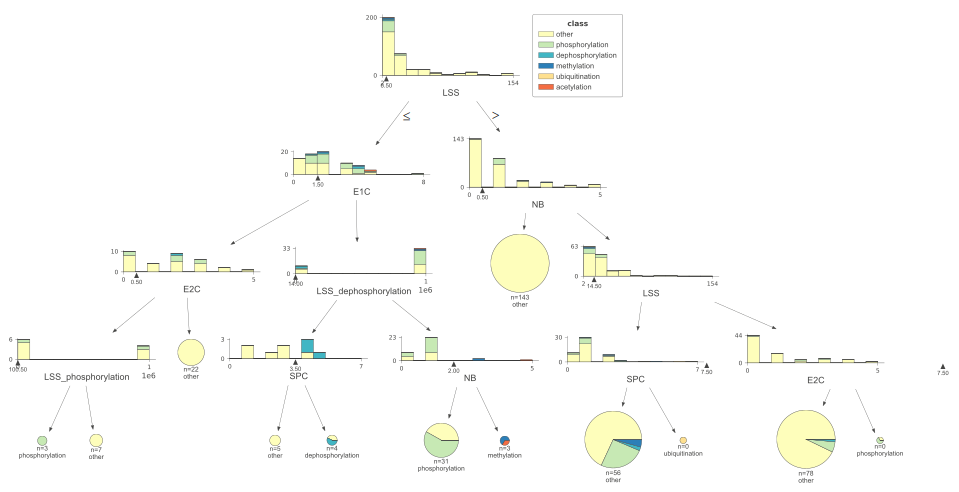

In [19]:
#plot_tree(result_test_gt[NAIVE_BAYES_WITH_TREE]["m"])

plot_tree_pretty(result_test_gt[NAIVE_BAYES_WITH_TREE]["m"], df_test["x"], df_test["y"])

### Test on train fit

In [20]:
result_train_predict_test_gt = predict_all_classifiers(df_test, result_test_gt)

print_report_all_classifiers(df_test["y"], result_train_predict_test_gt,  all_labels)



\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      96.8 &          Negative &   61.1 &     74.9 &     296 \\
       Naive Bayes &      33.9 &   Phosphorylation &   86.4 &     48.7 &      44 \\
       Naive Bayes &      25.0 & Dephosphorylation &  100.0 &     40.0 &       6 \\
       Naive Bayes &      26.7 &       Methylation &  100.0 &     42.1 &       4 \\
       Naive Bayes &      20.0 &    Ubiquitination &  100.0 &     33.3 &       1 \\
       Naive Bayes &      11.1 &       Acetylation &  100.0 &     20.0 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      65.6 &         micro avg &   65.6 &     65.6 &     352 \\
       Naive Bayes &      30.5 &         macro avg &   78.2 &     37.0 &     352 \\
       Naive Bayes &      86.5 &      weighted avg &   65.6 &     70.4 &     352 \\
Naive Bayes + Tree &      93.2 &  

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.967914,Negative,0.611486,0.749482,296.0
Phosphorylation,Naive Bayes,0.339286,Phosphorylation,0.863636,0.487179,44.0
Dephosphorylation,Naive Bayes,0.250000,Dephosphorylation,1.000000,0.400000,6.0
Methylation,Naive Bayes,0.266667,Methylation,1.000000,0.421053,4.0
Ubiquitination,Naive Bayes,0.200000,Ubiquitination,1.000000,0.333333,1.0
Acetylation,Naive Bayes,0.111111,Acetylation,1.000000,0.200000,1.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.656250,micro avg,0.656250,0.656250,352.0
macro avg,Naive Bayes,0.304997,macro avg,0.782160,0.370150,352.0
weighted avg,Naive Bayes,0.864514,weighted avg,0.656250,0.704262,352.0


### Predict Test on Test Prediction fit 

In [21]:
df_test_prediction = load_valtest_ensemble_pred(test_predictions_file)

result_test_bp = train_and_predict_all_classifiers(df_test_prediction, min_df=1)

print_report_all_classifiers(df_test_prediction["y"], result_test_bp,  pos_labels)

print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)



l_test_pred =  print_report_all_classifiers(df_test_prediction["y"], result_test_bp,  pos_labels)


Training Naive Bayes
Max words :  2349
Training Naive Bayes + Tree
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      27.4 &   Phosphorylation &   95.8 &     42.6 &      24 \\
       Naive Bayes &      16.7 & Dephosphorylation &  100.0 &     28.6 &       2 \\
       Naive Bayes &      57.1 &       Methylation &  100.0 &     72.7 &       4 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      10.0 &       Acetylation &  100.0 &     18.2 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      26.5 &         micro avg &   96.8 &     41.7 &      31 \\
       Naive Bayes &      18.5 &         macro avg &   66.0 &     27.0 &      31 \\
       Naive Bayes &      30.0 &      weighted avg &   96.8 &     44.8 &      31 \\
Naive Bayes + Tree &      81.0 &   Phosphorylation 

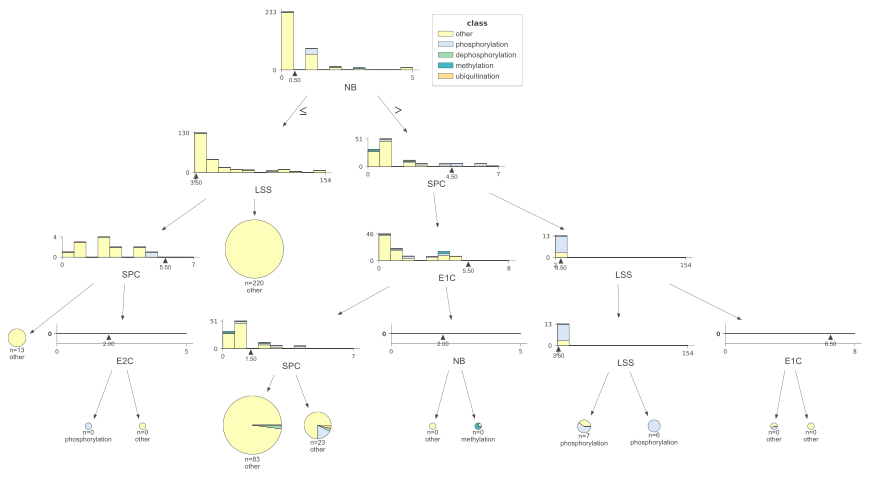

In [22]:
# plot_tree(result_test_bp[NAIVE_BAYES_WITH_TREE]["m"])
plot_tree_pretty(result_test_bp[NAIVE_BAYES_WITH_TREE]["m"], df_test_prediction["x"], df_test_prediction["y"])

In [23]:
t = l_test_pred.merge(l_test_gt,  on =["model", "index"])

print(t.to_latex(index=False, float_format= lambda x: f"{x:.1%}").replace("\%",""))

\begin{tabular}{lrlrrrrrrr}
\toprule
             model &  precision\_x &             index &  recall\_x &  f1-score\_x &  support\_x &  precision\_y &  recall\_y &  f1-score\_y &  support\_y \\
\midrule
       Naive Bayes &        27.4 &   Phosphorylation &     95.8 &       42.6 &    2400.0 &        33.9 &     86.4 &       48.7 &    4400.0 \\
       Naive Bayes &        16.7 & Dephosphorylation &    100.0 &       28.6 &     200.0 &        25.0 &    100.0 &       40.0 &     600.0 \\
       Naive Bayes &        57.1 &       Methylation &    100.0 &       72.7 &     400.0 &        26.7 &    100.0 &       42.1 &     400.0 \\
       Naive Bayes &         0.0 &    Ubiquitination &      0.0 &        0.0 &       0.0 &        20.0 &    100.0 &       33.3 &     100.0 \\
       Naive Bayes &        10.0 &       Acetylation &    100.0 &       18.2 &     100.0 &        11.1 &    100.0 &       20.0 &     100.0 \\
       Naive Bayes &         0.0 &  Deubiquitination &      0.0 &        0.0 &       0

### Test prediction on train fit

In [24]:
result_train_predict_test_bp = predict_all_classifiers(df_test_prediction, result_test_bp)

print_report_all_classifiers(df_test_prediction["y"], result_train_predict_test_bp,  all_labels)



\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      99.6 &          Negative &   74.1 &     85.0 &     321 \\
       Naive Bayes &      27.4 &   Phosphorylation &   95.8 &     42.6 &      24 \\
       Naive Bayes &      16.7 & Dephosphorylation &  100.0 &     28.6 &       2 \\
       Naive Bayes &      57.1 &       Methylation &  100.0 &     72.7 &       4 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      10.0 &       Acetylation &  100.0 &     18.2 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      76.1 &         micro avg &   76.1 &     76.1 &     352 \\
       Naive Bayes &      30.1 &         macro avg &   67.1 &     35.3 &     352 \\
       Naive Bayes &      93.5 &      weighted avg &   76.1 &     81.5 &     352 \\
Naive Bayes + Tree &      96.9 &  

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.995816,Negative,0.741433,0.850000,321.0
Phosphorylation,Naive Bayes,0.273810,Phosphorylation,0.958333,0.425926,24.0
Dephosphorylation,Naive Bayes,0.166667,Dephosphorylation,1.000000,0.285714,2.0
Methylation,Naive Bayes,0.571429,Methylation,1.000000,0.727273,4.0
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0
Acetylation,Naive Bayes,0.100000,Acetylation,1.000000,0.181818,1.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.761364,micro avg,0.761364,0.761364,352.0
macro avg,Naive Bayes,0.301103,macro avg,0.671395,0.352962,352.0
weighted avg,Naive Bayes,0.934510,weighted avg,0.761364,0.814587,352.0


## Fit large scale Negative high quality

In [25]:

local_hq_file= os.path.join(temp_dir, s3_large_scale_high_q.split("/")[-1])

download_file(s3_large_scale_high_q , temp_dir)

t = load_large_scale(local_hq_file)


df_largescale_negative_sample_hq = pd.concat([t.query("y==0").sample(n=5000, random_state=43),
                                              t.query("y==1").sample(n=250, random_state=43)])


result_largescale_negative_sample_hq  = train_and_predict_all_classifiers(df_largescale_negative_sample_hq)



print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_largescale_negative_sample_hq, pos_labels)

print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_largescale_negative_sample_hq, all_labels)





Training Naive Bayes
Max words :  79
Training Naive Bayes + Tree
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      71.5 &   Phosphorylation &   84.4 &     77.4 &     250 \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      71.5 &         micro avg &   84.4 &     77.4 &     250 \\
       Naive Bayes &      11.9 &         macro avg &   14.1 &     12.9 &     250 \\
       Naive Bayes &      71.5 &      weighted avg &   84.4 &     77.4 &     250 \\
Naive Bayes + Tree &      81.9 &   Phosphorylation & 

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.992129,Negative,0.983200,0.987644,5000.0
Phosphorylation,Naive Bayes,0.715254,Phosphorylation,0.844000,0.774312,250.0
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.0
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.0
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.976571,micro avg,0.976571,0.976571,5250.0
macro avg,Naive Bayes,0.243912,macro avg,0.261029,0.251708,5250.0
weighted avg,Naive Bayes,0.978945,weighted avg,0.976571,0.977486,5250.0


In [26]:
get_top_discrimintary_keywords(result_largescale_negative_sample_hq[NAIVE_BAYES]["m"],0)

[('protpart1', -2.124496139118884),
 ('protpart0', -2.136709260898316),
 ('prtig0', -2.418215661988649),
 ('prtig1', -2.5768396164460867),
 ('prtig2', -2.8919673912391186),
 ('cells', -2.943181064622607),
 ('prtig3', -3.2838020226882776),
 ('expression', -3.595761060193552),
 ('cell', -3.6169539063451914),
 ('prtig4', -3.684322547789881),
 ('prtig5', -4.153085896382419),
 ('protein', -4.260058015934587),
 ('induced', -4.274594398448228),
 ('human', -4.422876600830898),
 ('gene', -4.442040071791653),
 ('activity', -4.4491939091482715),
 ('levels', -4.488948097907697),
 ('binding', -4.505086156589525),
 ('prtig6', -4.510523907889654),
 ('effect', -4.704913630897094),
 ('expressed', -4.738586846003682),
 ('increased', -4.748222157987354),
 ('proteins', -4.797842542212775),
 ('factor', -4.813960107233844),
 ('protpart1 protpart1', -4.840907845643612),
 ('receptor', -4.84547059120203),
 ('protpart0 protpart0', -4.878006381253427),
 ('activation', -4.921456498179952),
 ('response', -4.938040

In [27]:
get_top_discrimintary_keywords(result_largescale_negative_sample_hq[NAIVE_BAYES]["m"] ,1)

[('protpart1', -1.898676846002835),
 ('protpart0', -1.909118326723254),
 ('phosphorylation', -2.8378912177789273),
 ('protein', -3.156646926855366),
 ('kinase', -3.1700250528015417),
 ('cells', -3.4084360762465398),
 ('phosphorylated', -3.670800340714031),
 ('activity', -3.710465597106462),
 ('cell', -3.92928325847355),
 ('protein kinase', -4.136369372891901),
 ('prtig0', -4.209796841446718),
 ('tyrosine', -4.320462409334238),
 ('dependent', -4.48173055693036),
 ('activation', -4.48173055693036),
 ('results', -4.519951769750557),
 ('vitro', -4.519951769750557),
 ('binding', -4.587091072588186),
 ('proteins', -4.629650687006982),
 ('protpart1 protpart0', -4.6442494864281345),
 ('purified', -4.674102449577816),
 ('protpart1 protpart1', -4.689369921708605),
 ('increase', -4.689369921708605),
 ('protpart0 protpart0', -4.73662280655915),
 ('human', -4.786219747698522),
 ('increased', -4.820705923769691),
 ('stimulated', -4.820705923769691),
 ('phosphorylation protpart1', -4.820705923769691)

### Fit to train

In [28]:
result_train_predict_largescale_negative_sample_hq = predict_all_classifiers(df_largescale_negative_sample_hq, train_result) 
 
print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_train_predict_largescale_negative_sample_hq, all_labels)

\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      98.9 &          Negative &   94.0 &     96.4 &    5000 \\
       Naive Bayes &      39.4 &   Phosphorylation &   78.0 &     52.3 &     250 \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      93.2 &         micro avg &   93.2 &     93.2 &    5250 \\
       Naive Bayes &      19.8 &         macro avg &   24.6 &     21.2 &    5250 \\
       Naive Bayes &      96.1 &      weighted avg &   93.2 &     94.3 &    5250 \\
Naive Bayes + Tree &      95.9 &  

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.988844,Negative,0.939600,0.963593,5000.0
Phosphorylation,Naive Bayes,0.393939,Phosphorylation,0.780000,0.523490,250.0
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.0
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.0
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.932000,micro avg,0.932000,0.932000,5250.0
macro avg,Naive Bayes,0.197541,macro avg,0.245657,0.212440,5250.0
weighted avg,Naive Bayes,0.960516,weighted avg,0.932000,0.942636,5250.0


## Fit large scale Negative low quality

In [29]:
local_lq_file= os.path.join(temp_dir, s3_large_scale_low_q.split("/")[-1])

download_file(s3_large_scale_low_q , temp_dir)



df_largescale_negative_sample_lq = load_large_scale(local_lq_file)
df_largescale_negative_sample_lq = pd.concat([df_largescale_negative_sample_lq.query("y==0").sample(n=5000, random_state=43),
                                              df_largescale_negative_sample_lq.query("y==1").sample(n=250, random_state=43 )])


result_largescale_negative_sample_lq  = train_and_predict_all_classifiers(df_largescale_negative_sample_lq)



print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_largescale_negative_sample_lq, pos_labels)

print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_largescale_negative_sample_lq, all_labels)






Training Naive Bayes
Max words :  58
Training Naive Bayes + Tree
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      34.1 &   Phosphorylation &   17.6 &     23.2 &     250 \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      34.1 &         micro avg &   17.6 &     23.2 &     250 \\
       Naive Bayes &       5.7 &         macro avg &    2.9 &      3.9 &     250 \\
       Naive Bayes &      34.1 &      weighted avg &   17.6 &     23.2 &     250 \\
Naive Bayes + Tree &     100.0 &   Phosphorylation & 

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.959773,Negative,0.983000,0.971248,5000.0
Phosphorylation,Naive Bayes,0.341085,Phosphorylation,0.176000,0.232190,250.0
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.0
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.0
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.944571,micro avg,0.944571,0.944571,5250.0
macro avg,Naive Bayes,0.185837,macro avg,0.165571,0.171920,5250.0
weighted avg,Naive Bayes,0.930312,weighted avg,0.944571,0.936055,5250.0


In [30]:
get_top_discrimintary_keywords(result_largescale_negative_sample_lq[NAIVE_BAYES]["m"],0)

[('protpart0', -1.7779326197342282),
 ('protpart1', -1.8035041305121329),
 ('prtig0', -2.765777587537043),
 ('cells', -2.7951089979932515),
 ('cell', -3.5218634361364067),
 ('prtig1', -3.6048908259281767),
 ('activity', -3.7496578948189656),
 ('protein', -4.113096503869351),
 ('binding', -4.127923793631768),
 ('expression', -4.128754013687757),
 ('induced', -4.1329154845290095),
 ('human', -4.197509609102887),
 ('levels', -4.225477151379985),
 ('10', -4.254249437754639),
 ('effect', -4.348994805344006),
 ('increased', -4.389126906770323),
 ('gene', -4.492334569067048),
 ('patients', -4.518970526315661),
 ('alpha', -4.526359722498032),
 ('increase', -4.530074897049896),
 ('response', -4.584900608272067),
 ('did', -4.590156862160893),
 ('protpart1 protpart0', -4.610117604723432),
 ('specific', -4.618214814956051),
 ('protpart0 protpart0', -4.620928520827647),
 ('results', -4.630484907547865),
 ('protpart1 protpart1', -4.644297281835477),
 ('protpart0 protpart1', -4.658303113024396),
 ('n

In [31]:
get_top_discrimintary_keywords(result_largescale_negative_sample_lq[NAIVE_BAYES]["m"],1)

[('protpart1', -1.6071445357563423),
 ('protpart0', -1.723826855836541),
 ('cells', -3.2479049193194838),
 ('prtig0', -3.5235386532550903),
 ('activity', -3.671719166095845),
 ('human', -3.8793585308740894),
 ('levels', -3.914144646959505),
 ('cell', -3.941052099879429),
 ('protein', -4.066821487168463),
 ('plasma', -4.119743888622805),
 ('patients', -4.164195651193639),
 ('expression', -4.198881209181529),
 ('binding', -4.234813218407592),
 ('protpart0 protpart1', -4.284823638982254),
 ('protpart1 protpart1', -4.284823638982254),
 ('effect', -4.297727043818162),
 ('gene', -4.324044352135536),
 ('induced', -4.324044352135536),
 ('alpha', -4.351073024523455),
 ('increased', -4.422024760495739),
 ('protpart0 protpart0', -4.43683984628088),
 ('results', -4.467145195776209),
 ('normal', -4.498397739280313),
 ('acid', -4.581089455125427),
 ('dose', -4.581089455125427),
 ('protpart1 protpart0', -4.5984811978372955),
 ('significantly', -4.634199280439375),
 ('observed', -4.652548419107571),
 

### Fit to train

In [32]:


result_train_predict_largescale_negative_sample_low_q = predict_all_classifiers(df_largescale_negative_sample_lq, train_result) 
 
print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_train_predict_largescale_negative_sample_low_q, all_labels)


\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      97.4 &          Negative &   72.2 &     82.9 &    5000 \\
       Naive Bayes &      10.1 &   Phosphorylation &   60.0 &     17.3 &     250 \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      71.6 &         micro avg &   71.6 &     71.6 &    5250 \\
       Naive Bayes &      15.4 &         macro avg &   18.9 &     14.3 &    5250 \\
       Naive Bayes &      93.3 &      weighted avg &   71.6 &     79.8 &    5250 \\
Naive Bayes + Tree &      95.2 &  

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.974089,Negative,0.721800,0.829179,5000.0
Phosphorylation,Naive Bayes,0.101146,Phosphorylation,0.600000,0.173110,250.0
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.0
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.0
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.716000,micro avg,0.716000,0.716000,5250.0
macro avg,Naive Bayes,0.153605,macro avg,0.188829,0.143184,5250.0
weighted avg,Naive Bayes,0.932520,weighted avg,0.716000,0.797937,5250.0


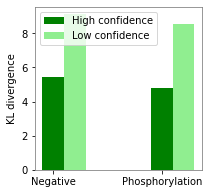

In [45]:
import numpy as np
import math

def _build_list(l1,l2):
    word_index = {w:i for i,(w,p) in enumerate(l1)}
    for w,_ in l2:
        if w not in word_index: word_index[w]=len(word_index)
    
    l1_r = [0.00000000000001   for _ in range(len(word_index))]
    for i, (w,p) in enumerate(l1):
        l1_r[word_index[w] ] = math.exp(p)
        
    l2_r = [0.00000000000001   for _ in range(len(word_index))]
    for i, (w,p) in enumerate(l2):
        l2_r[word_index[w] ] = math.exp(p)
    
    return l1_r,l2_r


def kl_divergence(p_keyword, q_keyword):
    p,q = _build_list(p_keyword, q_keyword)
    return sum(p[i] * math.log(p[i]/q[i]) for i in range(len(p)))


def compute_kl_divergence(p1_model_result, p2_model_result, label_names=label_names):
    result = []
    label_map = {
        "other" : "negative"
    }
    for i, l in enumerate(label_names):
        p = kl_divergence(get_top_discrimintary_keywords(p1_model_result[NAIVE_BAYES]["m"],i),
                     get_top_discrimintary_keywords(p2_model_result[NAIVE_BAYES]["m"],i)
                     )
        result.append({
            "label_name" : label_map.get(l, l).title() ,
            "label_index" : i,
            "kl" : p
        })
    return pd.DataFrame(result)
        
def plot_divergence(df1,t1, df2, t2, ax):

    ind = np.array([float(i) for i in df1["label_index"].values] )
    width = 0.2
    
    ax.bar(ind, df1["kl"], width, color='green', label=t1)
    ax.bar(ind + width,  df2["kl"], width, color='lightgreen', label=t2)
    
    ax.legend()
    
    ax.set_xticks(df1["label_index"].values)
    ax.set_xticklabels(df1["label_name"])
    
    ax.set_ylabel("KL divergence")
    
    ax.spines['bottom'].set_color('grey')
    ax.spines['top'].set_color('grey') 
    ax.spines['right'].set_color('grey')
    ax.spines['left'].set_color('grey')


        

_, ax= plt.subplots(1,1, figsize=(3,3))        
label_names = label_names[:2]
plot_divergence(compute_kl_divergence(result_largescale_negative_sample_hq, train_result, label_names),
                "High confidence", 
                compute_kl_divergence(result_largescale_negative_sample_lq, train_result, label_names), 
                "Low confidence",
                ax)



## Latex results

In [34]:
def prepare_latex(meta_dict_df, index_filter=None ):#["micro avg"]
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        if index_filter:
            df = df[df["index"].isin(index_filter)].copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    
    # Drop index if just one ..
    if df["index"].nunique() ==1:
        df_summ = df_summ.drop("index", axis=1)
    
    return df_summ
    

df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["y"], result_test_gt, all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)
df_summ_negative_sample_lq = print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_largescale_negative_sample_lq, all_labels)

df_summ_negative_sample_hq = print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_largescale_negative_sample_hq, all_labels)




df_summ = prepare_latex ([
                {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
     {"df": df_summ_negative_sample_lq, "meta":[{ "name": "dataset" , "value": "PTM GL"}, { "name": "T" , "value": "BP"}]},
     {"df": df_summ_negative_sample_hq, "meta":[{ "name": "dataset" , "value": "PTM GH"}, { "name": "T" , "value": "BP"}]}




                ],


              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      99.6 &          Negative &   74.1 &     85.0 &     321 \\
       Naive Bayes &      27.4 &   Phosphorylation &   95.8 &     42.6 &      24 \\
       Naive Bayes &      16.7 & Dephosphorylation &  100.0 &     28.6 &       2 \\
       Naive Bayes &      57.1 &       Methylation &  100.0 &     72.7 &       4 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      10.0 &       Acetylation &  100.0 &     18.2 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      76.1 &         micro avg &   76.1 &     76.1 &     352 \\
       Naive Bayes &      30.1 &         macro avg &   67.1 &     35.3 &     352 \\
       Naive Bayes &      93.5 &      weighted avg &   76.1 &     81.5 &     352 \\
Naive Bayes + Tree &      96.9 &  

In [35]:
df_summ_trainfit_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_train_predict_test_bp,  all_labels)
df_summ_trainfit_test_gt = print_report_all_classifiers(df_test["y"], result_train_predict_test_gt,  all_labels)
df_summ_trainfit_large_high = print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_train_predict_largescale_negative_sample_hq,  all_labels)
df_summ_trainfit_large_low = print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_train_predict_largescale_negative_sample_low_q,  all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)





df_summ_neg = prepare_latex ([
                    {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},


                {"df": df_summ_trainfit_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_trainfit_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
                {"df": df_summ_trainfit_large_high, "meta":[{ "name": "dataset" , "value": "PTM GH"}, { "name": "T" , "value": "BP"}]},
                {"df": df_summ_trainfit_large_low, "meta":[{ "name": "dataset" , "value": "PTM GL"}, { "name": "T" , "value": "BP"}]},





                ],
    index_filter=["Negative"]
              )

print("**Negative***")
print(df_summ_neg.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

df_summ_phos = prepare_latex ([
                        {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},


                {"df": df_summ_trainfit_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_trainfit_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
                {"df": df_summ_trainfit_large_high, "meta":[{ "name": "dataset" , "value": "PTM GH"}, { "name": "T" , "value": "BP"}]},
                {"df": df_summ_trainfit_large_low, "meta":[{ "name": "dataset" , "value": "PTM GL"}, { "name": "T" , "value": "BP"}]},





                ],
    index_filter=["Phosphorylation"]
              )

print("**Phosphorylation***")

print(df_summ_phos.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      99.6 &          Negative &   74.1 &     85.0 &     321 \\
       Naive Bayes &      27.4 &   Phosphorylation &   95.8 &     42.6 &      24 \\
       Naive Bayes &      16.7 & Dephosphorylation &  100.0 &     28.6 &       2 \\
       Naive Bayes &      57.1 &       Methylation &  100.0 &     72.7 &       4 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      10.0 &       Acetylation &  100.0 &     18.2 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      76.1 &         micro avg &   76.1 &     76.1 &     352 \\
       Naive Bayes &      30.1 &         macro avg &   67.1 &     35.3 &     352 \\
       Naive Bayes &      93.5 &      weighted avg &   76.1 &     81.5 &     352 \\
Naive Bayes + Tree &      96.9 &  

In [36]:
def prepare_latex(meta_dict_df):
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NBT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        df = df.copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    df_summ["index"] = df_summ["index"].apply(lambda x: label_names[int(x)] if isint(x) else x )
    
    return df_summ


df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["y"], result_test_gt, all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)



df_summ = prepare_latex ([
                {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
                ]
              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      99.6 &          Negative &   74.1 &     85.0 &     321 \\
       Naive Bayes &      27.4 &   Phosphorylation &   95.8 &     42.6 &      24 \\
       Naive Bayes &      16.7 & Dephosphorylation &  100.0 &     28.6 &       2 \\
       Naive Bayes &      57.1 &       Methylation &  100.0 &     72.7 &       4 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      10.0 &       Acetylation &  100.0 &     18.2 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      76.1 &         micro avg &   76.1 &     76.1 &     352 \\
       Naive Bayes &      30.1 &         macro avg &   67.1 &     35.3 &     352 \\
       Naive Bayes &      93.5 &      weighted avg &   76.1 &     81.5 &     352 \\
Naive Bayes + Tree &      96.9 &  